The purpose of this notebook is to:

1. Localize all the necessary data to run DSWx-SAR
2. Create a `yaml` file (proverbially called a RunConfig) for DSWx-SAR
3. Run DSWx-SAR
4. View the final products

Most of the code is focused on 1. There are some small todos:

+ Provide an option to serialize data (since re-localizing data takes time and all we need is path)
+ Possibly replace SLC_ID look up in HySDS PST DB with a look up in a table so users don't have to be on PST.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import asf_search as asf
import geopandas as gpd
import pandas as pd
import rasterio
from shapely.geometry import shape
from rasterio.crs import CRS
from pathlib import Path
from dem_stitcher import stitch_dem
from hand import compute_hand
from tile_stitcher import get_raster_from_tiles
from es_db import get_search_client, get_rtc_urls, download_rtc_products
from dataclasses import dataclass
from tempfile import NamedTemporaryFile

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
import concurrent.futures
from functools import lru_cache
from pathlib import Path

import requests
import urllib3
from dotenv import dotenv_values
from elasticsearch import Elasticsearch, RequestsHttpConnection
from elasticsearch_dsl import Q, Search
from tqdm import tqdm

urllib3.disable_warnings()

In [4]:
slc_id = 'S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A'

# Parameters

In [5]:
SLC_ID = 'S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A'

# Out Directory

In [6]:
out_directory = Path('out') / SLC_ID
out_directory.mkdir(exist_ok=True, parents=True)

## Get SLC Metadata

In [7]:
opts = asf.ASFSearchOptions(processingLevel=[asf.PRODUCT_TYPE.SLC],
                            beamMode=[asf.BEAMMODE.IW],
                            platform=[asf.PLATFORM.SENTINEL1]
                            )

resp = asf.granule_search([SLC_ID], opts=opts)
geometry = [shape(r.geojson()['geometry']) for r in resp]
df_slc = gpd.GeoDataFrame(geometry=geometry, crs=CRS.from_epsg(4326))
df_slc.head()

,geometry
0,"POLYGON ((-99.04952 37.27494, -98.77662 36.144..."


<Axes: >

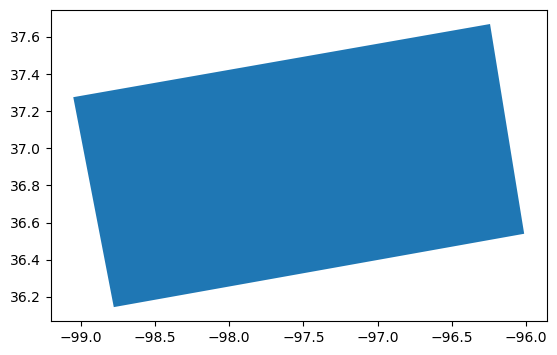

In [8]:
df_slc.plot()

# Auxiliary Datasets

## DEM

In [9]:
bounds = list(df_slc.total_bounds)
bounds

[-99.049522, 36.144268, -96.012474, 37.669025]

In [ ]:
dst_area_or_point = 'Point'
dem, p_dem = stitch_dem(bounds, 
                  'glo_30', 
                  dst_area_or_point=dst_area_or_point, 
                  dst_ellipsoidal_height=False)

Reading glo_30 Datasets: 100%|██████████| 8/8 [00:14<00:00,  1.75s/it]


In [ ]:
dem_path = out_directory / 'glo30_dem.tif'

In [ ]:
with rasterio.open(dem_path, 'w', **p_dem) as ds:
   ds.write(dem, 1)
   ds.update_tags(AREA_OR_POINT='Point')

## HAND

In [ ]:
%%time

hand = compute_hand(dem_path)

In [ ]:
hand_path = out_directory / f'hand.tif'

In [ ]:
with rasterio.open(hand_path, 'w', **p_dem) as ds:
    ds.write(hand, 1)

## Pekel

In [ ]:
X_occ, p_occ = get_raster_from_tiles(bounds, tile_shortname='peckel_water_occ_2021')

In [ ]:
occ_path = out_directory / 'pekel_occ.tif'

In [ ]:
with rasterio.open(occ_path, 'w', **p_occ) as ds:
    ds.write(X_occ)

## World Cover

In [ ]:
X_esa_wc, p_wc = get_raster_from_tiles(bounds, tile_shortname='esa_world_cover_2021')

In [ ]:
wc_path = out_directory / f'wc.tif'

In [ ]:
with rasterio.open(wc_path, 'w', **p_wc) as ds:
    ds.write(X_esa_wc)

In [ ]:
X_esa_wc.shape

# Delete Above Rasters in Memory

In [ ]:
del X_esa_wc
del dem
del hand
del X_occ

# Download RTC Data

Requires access to ES database and the `.env` file with JPL credentials.

In [ ]:
rtc_product_directory = out_directory / 'rtc_products'
rtc_product_directory.mkdir(exist_ok=True, parents=True)

In [ ]:
url_dict = get_rtc_urls(SLC_ID)

In [ ]:
out_paths = download_rtc_products(url_dict, rtc_product_directory)

# Generate Yaml/Runconfig

There are three general steps:

1. Get the defaults/templates
2. Populate the yml with our data
3. Load the yml as a Runconfig object for the workflow.

The way we figured this out was to keep going through the 3 steps and try running the RunConfig initialization `RunConfig.load_from_yaml`. Usually the loading tells the user what needs filling out on account of yaml validation.

In [ ]:
dswx_sar_pge_url = 'https://raw.githubusercontent.com/opera-adt/DSWX-SAR/main/src/dswx_sar/defaults/dswx_s1.yaml'
dswx_sar_param_url = 'https://raw.githubusercontent.com/opera-adt/DSWX-SAR/main/src/dswx_sar/defaults/algorithm_parameter_s1.yaml'

## Load default ymls from upstream repository

In [ ]:
resp = requests.get(dswx_sar_pge_url)
resp_param = requests.get(dswx_sar_param_url)

In [ ]:
# param_dict = yaml.safe_load(resp_param.content)
# param_dict

In [ ]:
input_dict = yaml.safe_load(resp.content)
input_dict

## Injecting parameters in relevant yml

In [ ]:
rtc_paths = list(rtc_product_directory.glob('*/'))
rtc_paths_str = list(map(str, rtc_paths))
rtc_paths_str = list(map(lambda s: s + '/', rtc_paths_str))
rtc_paths_str[:3]

In [ ]:
scratch_dir = (out_directory / 'scratch').resolve()
sas_dir = (out_directory / 'scratch').resolve()
product_dir = (out_directory / 'product_path').resolve()

In [ ]:
input_dict['runconfig']['groups']['input_file_group']['input_file_path'] = rtc_paths_str
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['dem_file']= str(dem_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['worldcover_file']= str(wc_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['hand_file']= str(hand_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['reference_water_file']= str(occ_path.resolve())
input_dict['runconfig']['groups']['product_path_group']['scratch_path'] = str(scratch_dir)
input_dict['runconfig']['groups']['product_path_group']['sas_output_path'] = str(sas_dir)
input_dict['runconfig']['groups']['product_path_group']['product_path'] = str(product_dir)

input_dict['runconfig']['groups']['primary_executable']['product_type'] = 'dswx_s1'
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['algorithm_parameters'] = 'params.yml'
input_dict['runconfig']['groups']['static_ancillary_file_group']['static_ancillary_inputs_flag'] = False

Make sure empty string rather than `None` is populated in yml.

In [ ]:
# See: https://stackoverflow.com/a/41786451
def represent_none(self, _):
    return self.represent_scalar('tag:yaml.org,2002:null', '')

yaml.add_representer(type(None), represent_none)

In [ ]:
log_path = str(out_directory/f'{SLC_ID}.log')

@dataclass
class Args:
    """placeholder"""
    debug_mode = False
    log_file = log_path

In [ ]:
args = Args()

If it fails, can inspect temporary file before deleted.

In [ ]:
with NamedTemporaryFile(mode='w', suffix='.yml', dir='.') as run_config_yaml:
    yaml.dump(input_dict, run_config_yaml)
    cfg = RunConfig.load_from_yaml(run_config_yaml.name, 'dswx_s1', args)

# Run Workflow

In [ ]:
from dswx_sar.dswx_s1 import dswx_s1_workflow

dswx_s1_workflow(cfg)